<a href="https://colab.research.google.com/github/fcoliveira-utfpr/climate_parana/blob/main/analises_clima_parana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Início - Bibliotecas
---

In [1]:
# -------------------------
# IMPORTS
# -------------------------
!pip install geobr   -q
import numpy as np
import pandas as pd
import geopandas as gpd
import pandas as pd
from geobr import read_municipality
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import matplotlib.colors as colors
import matplotlib.cm as cm
from geobr import read_municipality
from matplotlib.ticker import FuncFormatter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.8 MB/s eta 0:00:00


# Abrindo dados
---

In [2]:
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep = ",")
df

,estado,lat,lon,municipio,valor,variavel,ZC
0,Parana,-23.311363,-50.306176,ABATIA,210.718086,def,7601
1,Parana,-25.884047,-53.640829,BELA VISTA DA CAROBA,87.526841,def,6801
2,Parana,-24.781986,-48.819381,ADRIANOPOLIS,54.045608,def,6801
3,Parana,-26.025501,-49.309155,AGUDOS DO SUL,33.173108,def,6801
4,Parana,-25.284879,-49.322794,ALMIRANTE TAMANDARE,35.327444,def,6801
...,...,...,...,...,...,...,...
2395,Parana,-23.538200,-53.825424,ALTO PARAISO,28.208377,tmmx,7701
2396,Parana,-25.408510,-52.236439,VIRMOND,24.368879,tmmx,6801
2397,Parana,-26.277366,-52.804057,VITORINO,24.684439,tmmx,6901
2398,Parana,-23.853953,-49.783944,WENCESLAU BRAZ,25.967448,tmmx,7601


#Plotando mapa variáveis
---

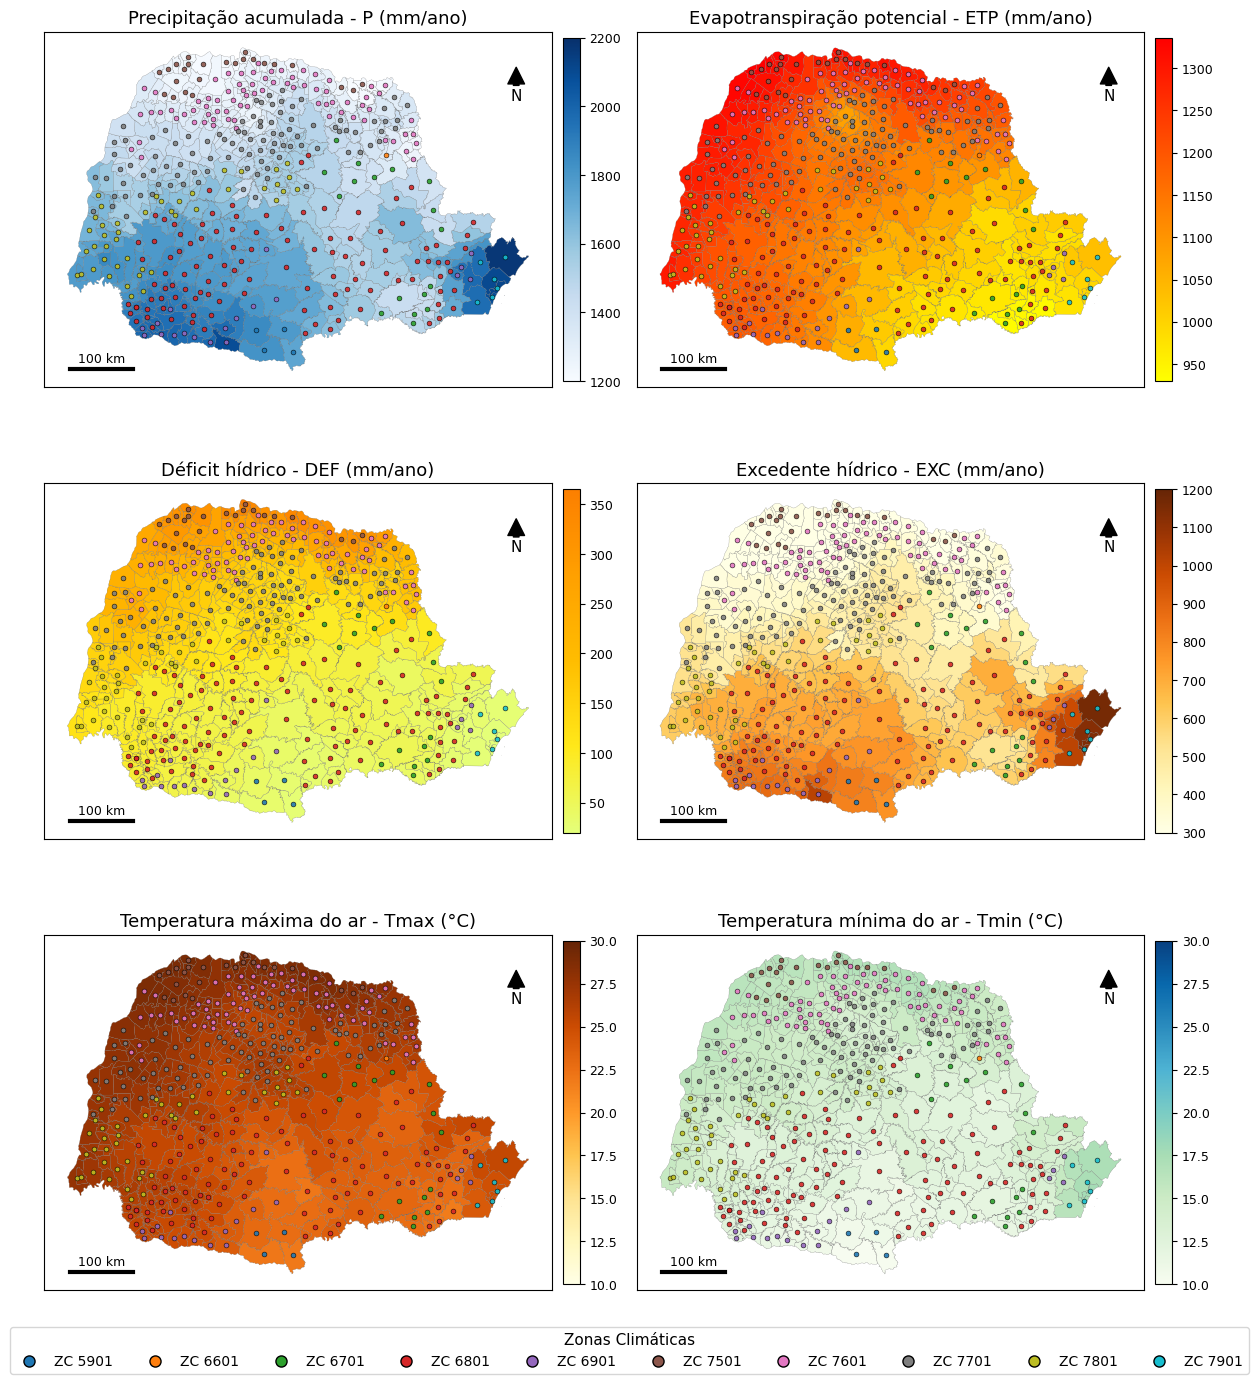

In [16]:
# =========================================================
# MULTIPLOT CLIMÁTICO – PARANÁ
# MAPAS CONTÍNUOS + ZONAS CLIMÁTICAS (LEGENDA ÚNICA)
# =========================================================

import math
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import geopandas as gpd
from geobr import read_municipality

# ---------------------------------------------------------
# SILENCIAR WARNINGS
# ---------------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------
# FUNÇÕES AUXILIARES
# -------------------------
def fmt_factory(fmt):
    return FuncFormatter(lambda x, pos: fmt % x)

def add_north_arrow(ax, x=0.93, y=0.9, size=0.08):
    ax.annotate(
        'N',
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor='black', width=4, headwidth=12),
        ha='center',
        va='center',
        fontsize=11,
        xycoords=ax.transAxes
    )

def add_scalebar(ax, length_km=100, loc=(0.05, 0.05), linewidth=3):
    x0, y0 = loc
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    length_deg = length_km / 111.0  # aproximação

    x_start = xlim[0] + x0 * (xlim[1] - xlim[0])
    y_start = ylim[0] + y0 * (ylim[1] - ylim[0])

    ax.plot(
        [x_start, x_start + length_deg],
        [y_start, y_start],
        color='black',
        linewidth=linewidth,
        zorder=20
    )

    ax.text(
        x_start + length_deg / 2,
        y_start + 0.01 * (ylim[1] - ylim[0]),
        f"{length_km} km",
        ha='center',
        va='bottom',
        fontsize=9
    )

# -------------------------
# ESPECIFICAÇÕES DAS VARIÁVEIS
# -------------------------
VAR_SPECS = {
    'pr':   dict(title="Precipitação acumulada - P",        unit="mm/ano", cmap='Blues',    vmin=1200, vmax=2200, fmt="%.0f"),
    'pet':  dict(title="Evapotranspiração potencial - ETP", unit="mm/ano", cmap='autumn_r', vmin=930,  vmax=1336, fmt="%.0f"),
    'def':  dict(title="Déficit hídrico - DEF",              unit="mm/ano", cmap='Wistia',   vmin=20,   vmax=365,  fmt="%.0f"),
    'ro':   dict(title="Excedente hídrico - EXC",            unit="mm/ano", cmap='YlOrBr',   vmin=300,  vmax=1200, fmt="%.0f"),
    'tmmx': dict(title="Temperatura máxima do ar - Tmax",    unit="°C",     cmap='YlOrBr',   vmin=10,   vmax=30,   fmt="%.1f"),
    'tmmn': dict(title="Temperatura mínima do ar - Tmin",    unit="°C",     cmap='GnBu',     vmin=10,   vmax=30,   fmt="%.1f"),
}

vars_plot = list(VAR_SPECS.keys())

# -------------------------
# CORES DAS ZONAS CLIMÁTICAS (EXPLÍCITAS)
# >>> EDITE AQUI SE QUISER <<<
# -------------------------
ZC_COLORS = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

# -------------------------
# DEFINIR ZONAS CLIMÁTICAS (FONTE CORRETA: DF)
# -------------------------
zonas = sorted(df['ZC'].dropna().unique(), key=lambda x: str(x))

if len(zonas) > len(ZC_COLORS):
    raise ValueError("Número de ZCs maior que a lista de cores.")

zona_color = {z: ZC_COLORS[i] for i, z in enumerate(zonas)}

# -------------------------
# MUNICÍPIOS DO PARANÁ
# -------------------------
mun_pr = read_municipality(code_muni="PR", year=2020)

mun_pr['municipio'] = (
    mun_pr['name_muni']
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
)

# -------------------------
# LAYOUT DA FIGURA
# -------------------------
n_vars = len(vars_plot)
ncols = 2
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 5 * nrows)
)

axes = axes.flatten()

# -------------------------
# LOOP DE MAPAS
# -------------------------
for i, variavel in enumerate(vars_plot):

    ax = axes[i]
    spec = VAR_SPECS[variavel]

    df_variavel = df[df['variavel'] == variavel].copy()

    df_variavel['municipio'] = (
        df_variavel['municipio']
        .str.upper()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
    )

    gdf_pr = mun_pr.merge(df_variavel, on='municipio', how='left')

    # -------------------------
    # MAPA CONTÍNUO
    # -------------------------
    gdf_pr.plot(
        column='valor',
        cmap=spec['cmap'],
        vmin=spec['vmin'],
        vmax=spec['vmax'],
        linewidth=0.15,
        edgecolor='0.4',
        ax=ax
    )

    # -------------------------
    # COLORBAR
    # -------------------------
    norm = colors.Normalize(vmin=spec['vmin'], vmax=spec['vmax'])
    sm = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(spec['cmap']))
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.046,
        pad=0.02,
        shrink=0.72,
        format=fmt_factory(spec['fmt'])
    )
    cbar.ax.tick_params(labelsize=9)

    # -------------------------
    # CENTROIDES (CRS PROJETADO)
    # -------------------------
    gdf_pr = gdf_pr.to_crs(epsg=5880)
    gdf_pr['centroid'] = gdf_pr.geometry.centroid
    gdf_pr = gdf_pr.to_crs(epsg=4674)

    # -------------------------
    # PONTOS DAS ZONAS CLIMÁTICAS
    # -------------------------
    for z in zonas:
        sub = gdf_pr[gdf_pr['ZC'] == z]
        if sub.empty:
            continue

        ax.scatter(
            sub.centroid.x,
            sub.centroid.y,
            s=12,
            color=zona_color[z],
            edgecolor='black',
            linewidth=0.4,
            alpha=0.9,
            zorder=10
        )

    # -------------------------
    # ELEMENTOS CARTOGRÁFICOS
    # -------------------------
    add_scalebar(ax, length_km=100)
    add_north_arrow(ax)

    ax.set_title(f"{spec['title']} ({spec['unit']})", fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])

# -------------------------
# REMOVER SUBPLOTS VAZIOS
# -------------------------
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# -------------------------
# LEGENDA ÚNICA – HORIZONTAL
# -------------------------
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='none',
        label=f'ZC {z}',
        markerfacecolor=zona_color[z],
        markeredgecolor='black',
        markersize=8
    )
    for z in zonas
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=len(zonas),
    frameon=True,
    title='Zonas Climáticas',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(0.5, 0.05)
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()
